# Project 3: Poisonous mushrooms

In this project, I investigated properties of mushrooms using a classic dataset containing over 8000 observations, where each mushroom is described by a variety of features (color, odor, etc.), and the target variable indicates whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space.

I began by running PCA to reduce the dimensionality from 126 down to 2 so that I could more easily visualize the data. In general, PCA is useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). 

Once I projected the data to 2 dimensions, I experimented with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, I train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and performed inference by comparing the probabilities output by each model.

In [152]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from itertools import compress

Load feature names.

In [5]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [6]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [15]:

kValues = list(range(1,51))

for k in kValues:
    pca = PCA(n_components=k)
    components = pca.fit_transform(train_data)
    print k, ' principle component(s) explain', sum(pca.explained_variance_ratio_)*100, '% of total variance \n'


1  principle component(s) explain 16.404331279333505 % of total variance 

2  principle component(s) explain 29.7278101487791 % of total variance 

3  principle component(s) explain 39.9012666709077 % of total variance 

4  principle component(s) explain 46.964623105418106 % of total variance 

5  principle component(s) explain 50.831268668111605 % of total variance 

6  principle component(s) explain 54.5120694782736 % of total variance 

7  principle component(s) explain 57.64030610906905 % of total variance 

8  principle component(s) explain 60.37401558324328 % of total variance 

9  principle component(s) explain 62.9905310656126 % of total variance 

10  principle component(s) explain 65.22129527415062 % of total variance 

11  principle component(s) explain 67.26959215881003 % of total variance 

12  principle component(s) explain 69.13783908541407 % of total variance 

13  principle component(s) explain 70.86114762256204 % of total variance 

14  principle component(s) explain 

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

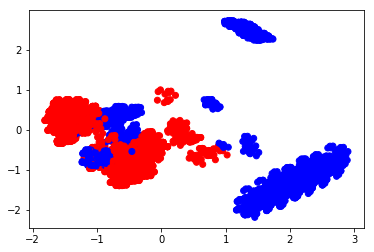

In [51]:

pca = PCA(n_components = 2)
components = pca.fit_transform(train_data)

colors = []
for i in train_labels:
    if i == 0: colors.append('r')
    if i == 1: colors.append('b')


plt.scatter(*zip(*components), c = colors)


Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

"\n    plt.scatter(estimator.cluster_centers_[:, 0], estimator.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')\n\n"

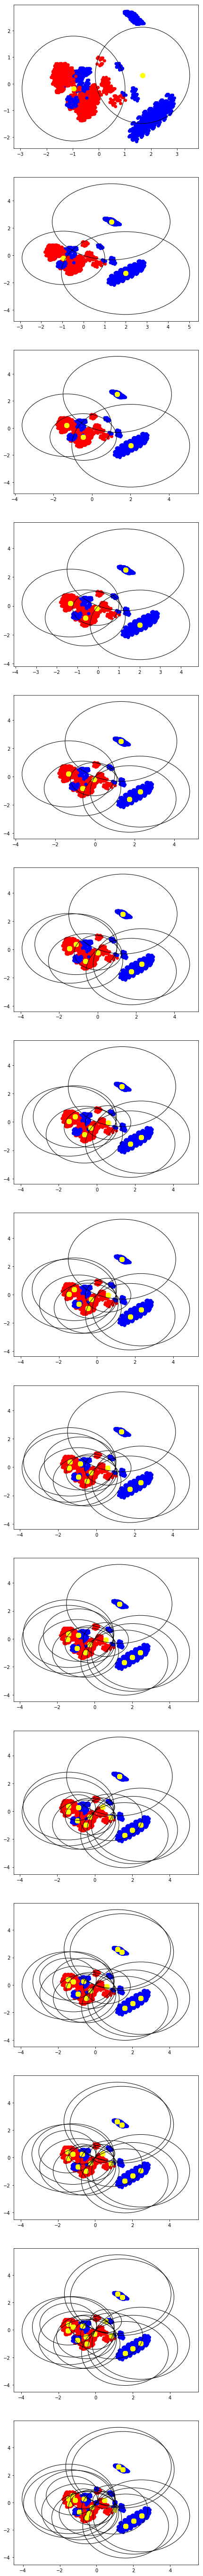

In [102]:

kValues = list(range(2,17))

pca = PCA(n_components = 2)
components = pca.fit_transform(train_data)

fig, ax = plt.subplots(15,1,figsize=(7,100))

for j in kValues:

    ax[j-2].scatter(*zip(*components), c = colors)
    clusters_centroids=dict()
    clusters_radii= dict()
    estimator = KMeans(n_clusters = j)
    y_kmeans = estimator.fit_predict(components)

    for cluster in list(range(0,j)):

            clusters_centroids[cluster]=list(zip(estimator.cluster_centers_[:, 0],estimator.cluster_centers_[:,1]))[cluster]
            clusters_radii[cluster]=max(np.linalg.norm(np.array(zip(i))-np.array(zip(clusters_centroids[cluster]))) for i in zip(train_data[y_kmeans == cluster, 0],train_data[y_kmeans == cluster, 1]))

            plt.scatter(train_data[y_kmeans == cluster, 0], train_data[y_kmeans == cluster, 1], s = 100, c = 'b')
            art = mpatches.Circle(clusters_centroids[cluster],clusters_radii[cluster],fill=False)
            ax[j-2].add_patch(art)
    
            ax[j-2].scatter(estimator.cluster_centers_[:, 0], estimator.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')


Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0.]
[-0.33780426  2.90893381]


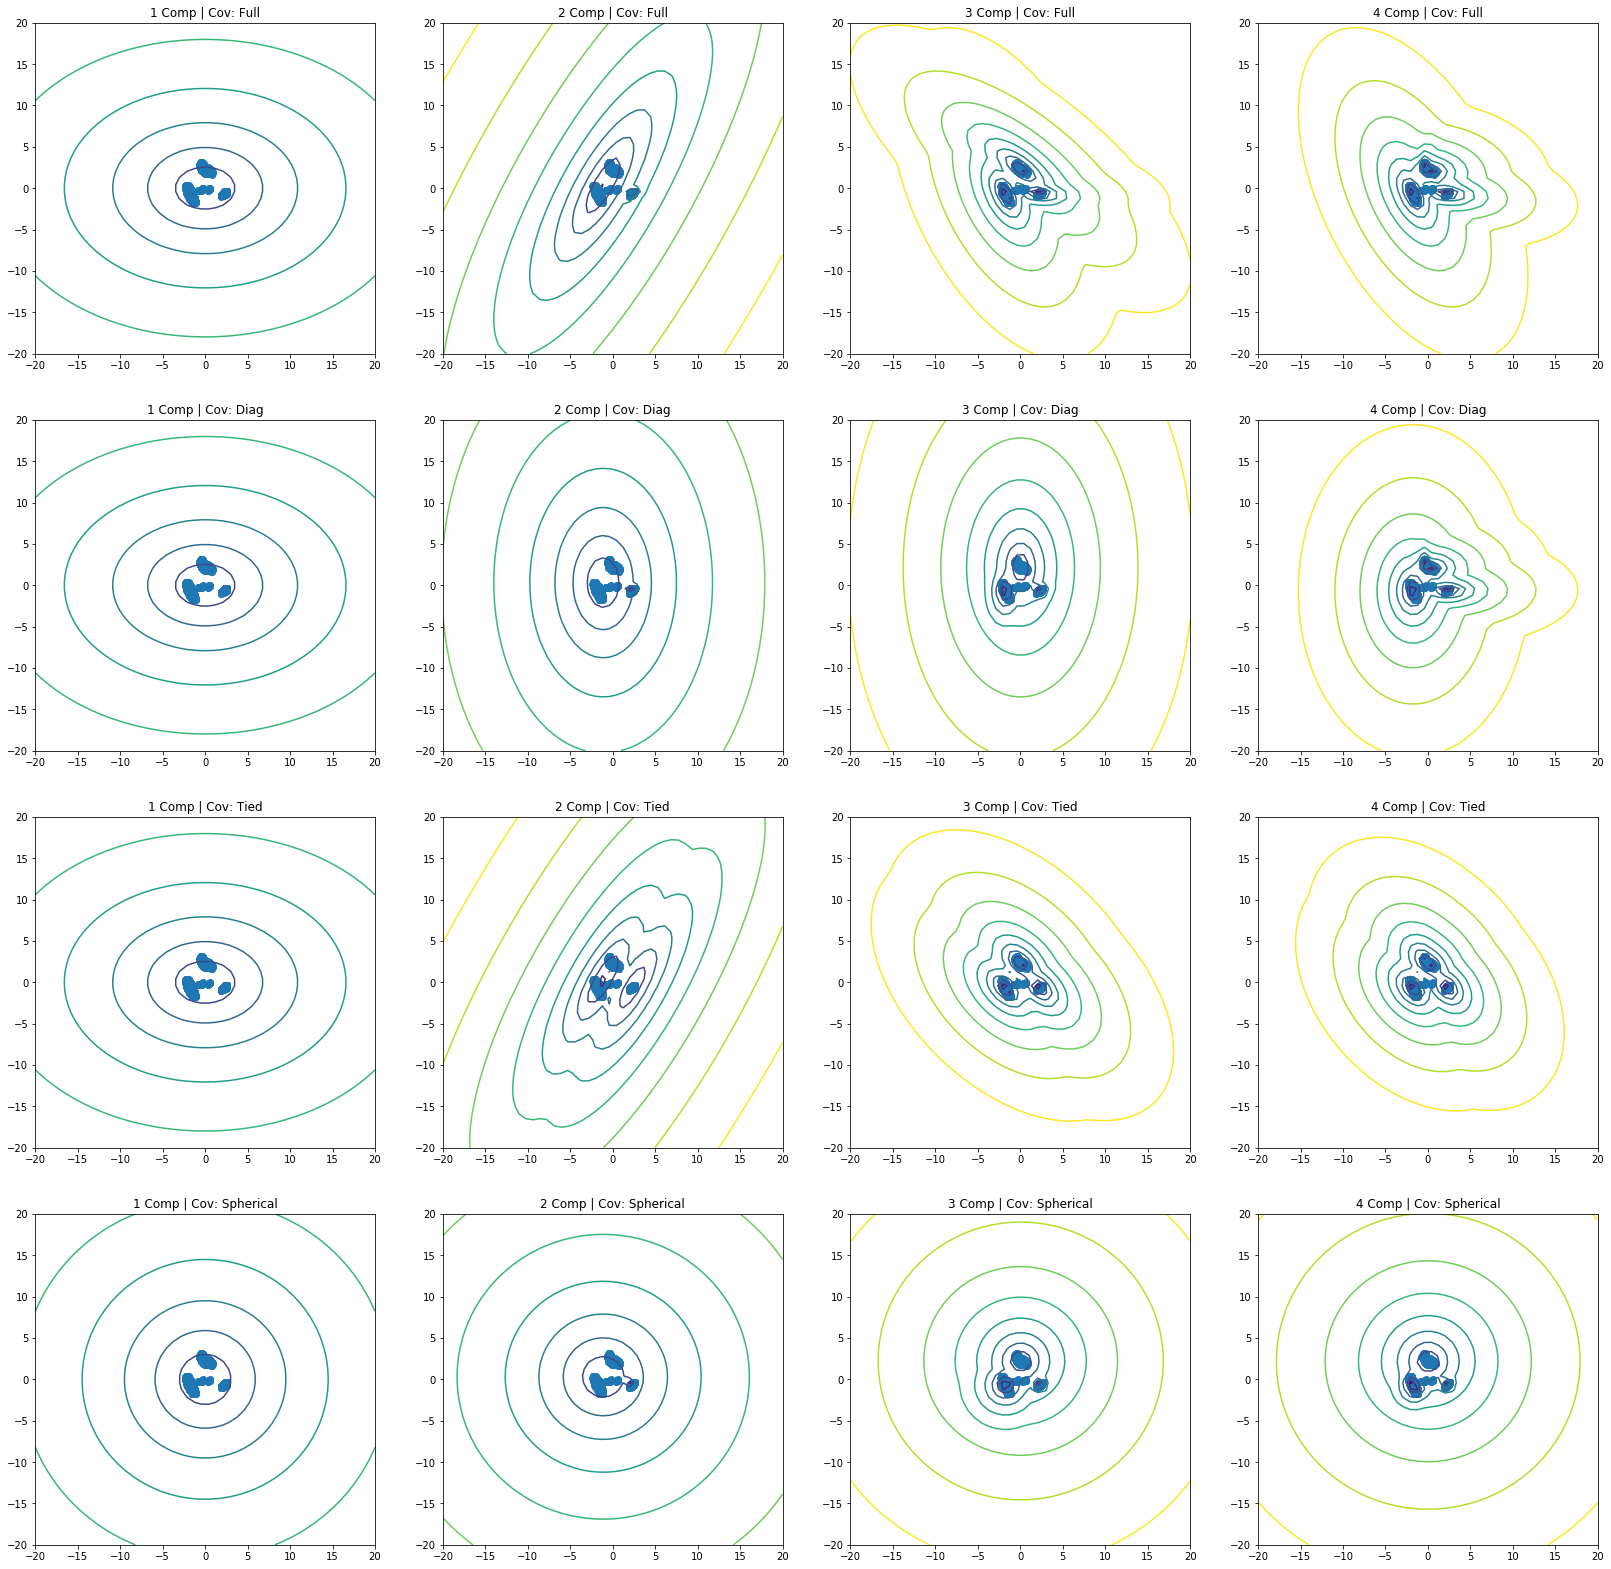

In [179]:

# Setting 2D PCA data + Setting Subplots
pca = PCA(n_components = 2)
positive = list(compress(train_data, train_labels))
components = pca.fit_transform(positive)
fig, ax = plt.subplots(4,4,figsize=(28,28))

# Setting all GMM variations

gmm1_full = GaussianMixture(n_components = 1, covariance_type = 'full')
gmm1_diag = GaussianMixture(n_components = 1, covariance_type = 'diag')
gmm1_tied = GaussianMixture(n_components = 1, covariance_type = 'tied')
gmm1_sph = GaussianMixture(n_components = 1, covariance_type = 'spherical')

gmm2_full = GaussianMixture(n_components = 2, covariance_type = 'full')
gmm2_diag = GaussianMixture(n_components = 2, covariance_type = 'diag')
gmm2_tied = GaussianMixture(n_components = 2, covariance_type = 'tied')
gmm2_sph = GaussianMixture(n_components = 2, covariance_type = 'spherical')

gmm3_full = GaussianMixture(n_components = 3, covariance_type = 'full')
gmm3_diag = GaussianMixture(n_components = 3, covariance_type = 'diag')
gmm3_tied = GaussianMixture(n_components = 3, covariance_type = 'tied')
gmm3_sph = GaussianMixture(n_components = 3, covariance_type = 'spherical')

gmm4_full = GaussianMixture(n_components = 4, covariance_type = 'full')
gmm4_diag = GaussianMixture(n_components = 4, covariance_type = 'diag')
gmm4_tied = GaussianMixture(n_components = 4, covariance_type = 'tied')
gmm4_sph = GaussianMixture(n_components = 4, covariance_type = 'spherical')

# Plotting each variation of GMM
# GMM Full - 1 component
gmm1_full.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm1_full.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[0,0].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))

ax[0,0].scatter(components[:, 0], components[:, 1])

ax[0,0].set_title('1 Comp | Cov: Full')
ax[0,0].axis('tight')

# GMM Full - 2 component
gmm2_full.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm2_full.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[0,1].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[0,1].scatter(components[:, 0], components[:, 1])

ax[0,1].set_title('2 Comp | Cov: Full')
ax[0,1].axis('tight')

# GMM Full - 3 component
gmm3_full.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm3_full.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[0,2].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[0,2].scatter(components[:, 0], components[:, 1])

ax[0,2].set_title('3 Comp | Cov: Full')
ax[0,2].axis('tight')

# GMM Full - 4 component
gmm4_full.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm4_full.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[0,3].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[0,3].scatter(components[:, 0], components[:, 1])

ax[0,3].set_title('4 Comp | Cov: Full')
ax[0,3].axis('tight')

# GMM Diag - 1 component
gmm1_diag.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm1_diag.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[1,0].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[1,0].scatter(components[:, 0], components[:, 1])

ax[1,0].set_title('1 Comp | Cov: Diag')
ax[1,0].axis('tight')

# GMM Diag - 2 component
gmm2_diag.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm2_diag.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[1,1].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[1,1].scatter(components[:, 0], components[:, 1])

ax[1,1].set_title('2 Comp | Cov: Diag')
ax[1,1].axis('tight')

# GMM Diag - 3 component
gmm3_diag.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm3_diag.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[1,2].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[1,2].scatter(components[:, 0], components[:, 1])

ax[1,2].set_title('3 Comp | Cov: Diag')
ax[1,2].axis('tight')

# GMM Diag - 4 component
gmm4_diag.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm4_diag.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[1,3].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[1,3].scatter(components[:, 0], components[:, 1])

ax[1,3].set_title('4 Comp | Cov: Diag')
ax[1,3].axis('tight')

# GMM Tied - 1 component
gmm1_tied.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm1_tied.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[2,0].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[2,0].scatter(components[:, 0], components[:, 1])

ax[2,0].set_title('1 Comp | Cov: Tied')
ax[2,0].axis('tight')

# GMM Tied - 2 component
gmm2_tied.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm2_tied.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[2,1].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[2,1].scatter(components[:, 0], components[:, 1])

ax[2,1].set_title('2 Comp | Cov: Tied')
ax[2,1].axis('tight')

# GMM Tied - 3 component
gmm3_tied.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm3_tied.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[2,2].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[2,2].scatter(components[:, 0], components[:, 1])

ax[2,2].set_title('3 Comp | Cov: Tied')
ax[2,2].axis('tight')

# GMM Tied - 4 component
gmm4_tied.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm4_tied.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[2,3].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[2,3].scatter(components[:, 0], components[:, 1])

ax[2,3].set_title('4 Comp | Cov: Tied')
ax[2,3].axis('tight')

# GMM Spherical - 1 component
gmm1_sph.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm1_sph.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[3,0].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[3,0].scatter(components[:, 0], components[:, 1])

ax[3,0].set_title('1 Comp | Cov: Spherical')
ax[3,0].axis('tight')

# GMM Spherical - 2 component
gmm2_sph.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm2_sph.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[3,1].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[3,1].scatter(components[:, 0], components[:, 1])

ax[3,1].set_title('2 Comp | Cov: Spherical')
ax[3,1].axis('tight')

# GMM Spherical - 3 component
gmm3_sph.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm3_sph.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[3,2].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[3,2].scatter(components[:, 0], components[:, 1])

ax[3,2].set_title('3 Comp | Cov: Spherical')
ax[3,2].axis('tight')

# GMM Spherical - 4 component
gmm4_sph.fit(components)

x = np.linspace(-20., 20.)
y = np.linspace(-20., 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm4_sph.score_samples(XX)
Z = Z.reshape(X.shape)

CS = ax[3,3].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
ax[3,3].scatter(components[:, 0], components[:, 1])

ax[3,3].set_title('4 Comp | Cov: Spherical')
ax[3,3].axis('tight')

print positive[1]
print components[1]
plt.show()


Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [222]:

# Define base PCA model
pca = PCA(n_components = 2)

# Invert train_labels to select negative instances
inverted_labels = [not i for i in train_labels]

# Generate subsets of positive and negative observations
positive = list(compress(train_data, train_labels))
negative = list(compress(train_data, inverted_labels))

# Fit PCA model to complete training data
components = pca.fit_transform(train_data)

# transform positive and negative subsets of train_data as well as the test set
posComp = pca.transform(positive)
negComp = pca.transform(negative)
testComp = pca.transform(test_data)

# generate two models for positive and negative cases, and fit them to respective transformed data sets
gmm4_full_p = GaussianMixture(n_components = 4, covariance_type = 'full')
gmm4_full_n = GaussianMixture(n_components = 4, covariance_type = 'full')

posGMM = gmm4_full_p.fit(posComp)
negGMM = gmm4_full_n.fit(negComp)

#Define answers list, and generate list of log-probabilities for each model.
answers = []

posProb = posGMM.score_samples(testComp)
negProb = negGMM.score_samples(testComp)

#Populate final answers list given relative probabilities for each observation
for index, i in enumerate(posProb):
    if np.exp(posProb[index]) < np.exp(negProb[index]):
        answers.append(0)
    else:
        answers.append(1)


print 'Accuracy: ', metrics.accuracy_score(test_labels, answers)*100, '%'



Accuracy:  95.01779359430606 %


Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [239]:


# Setting parameter to test
n_pca = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
n_gmm = [1,2,3,4,5,6,7,8,9,10,11,12]
cov_type = ['full', 'diag', 'tied', 'spherical']

# Defining metrics I would like to track across all models tested
bestAccuracy = 0
bestCovType = 'na'
modelstested = 0
bestNGMM = 0
bestNPCA = 0
bestParams = 0

# Use nested for loops to test all potential models with less than 50 parameters

for c in cov_type:
    for a in n_pca:
            for b in n_gmm: 
            
                # Calculate number of components based on covariance matrix type.
                if c == 'spherical':
                    cov_comp = 1
                elif c == 'diag':
                    cov_comp = a
                else:
                    cov_comp = a**2

                # Calculate number of parameters
                params = (((a + cov_comp)*b)*2)
                
                if params <= 50:
                    modelstested += 1
                    pca = PCA(n_components = a)
                    components = pca.fit_transform(train_data)
                    test_components = pca.transform(test_data)
                    gmm = GaussianMixture(n_components = b, covariance_type = c)
                    test_gmm = gmm.fit(components)
                    preds = test_gmm.predict(test_components)
                    score = metrics.accuracy_score(test_labels, preds)*100
                    if score >= bestAccuracy:
                        bestAccuracy = score
                        bestCovType = c
                        bestNGMM = b
                        bestNPCA = a
                        bestParams = params

                        
print 'Out of ', modelstested, 'models | Best Parameters [', bestNPCA, ', ', bestNGMM, ', ', bestCovType, '] | params = ', bestParams, '| accuracy = ', bestAccuracy 
                    
                                 


Out of  127 models | Best Parameters [ 3 ,  2 ,  full ] | params =  48 | accuracy =  89.1459074733096
